<a href="https://colab.research.google.com/github/ritup-1762/IMAGE-CLASSIFICATION-USING-MACHINE-LEARNING/blob/main/ImageClassification_using_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 67.4 MB/s eta 0:00:00
Mounted at /content/drive


METADATA:


FILE INFO
  File Path: input_folder/image_prj_f.img
  File Type: HFA Image
  Number of Layers: 4
  File Size: 2.31 MB

LAYER INFO
  Width: 483
  Height: 520
  Block Width: 483
  Block Height: 512
  Type: Continuous
  Data Type: uint16
  Compression: None

STATISTICS INFO (Excluding Zero Values)
  BAND 1 (Blue):
    ▪ Min: 635
    ▪ Max: 10808
    ▪ Mean: 1639.11
    ▪ Median: 1626.0
    ▪ Mode: 1772
    ▪ Std. Dev: 433.43

  BAND 2 (Green):
    ▪ Min: 972
    ▪ Max: 11680
    ▪ Mean: 1968.21
    ▪ Median: 1941.0
    ▪ Mode: 2058
    ▪ Std. Dev: 439.59

  BAND 3 (Red):
    ▪ Min: 1080
    ▪ Max: 13432
    ▪ Mean: 2115.14
    ▪ Median: 2118.0
    ▪ Mode: 2238
    ▪ Std. Dev: 568.91

  BAND 4 (NIR):
    ▪ Min: 1
   

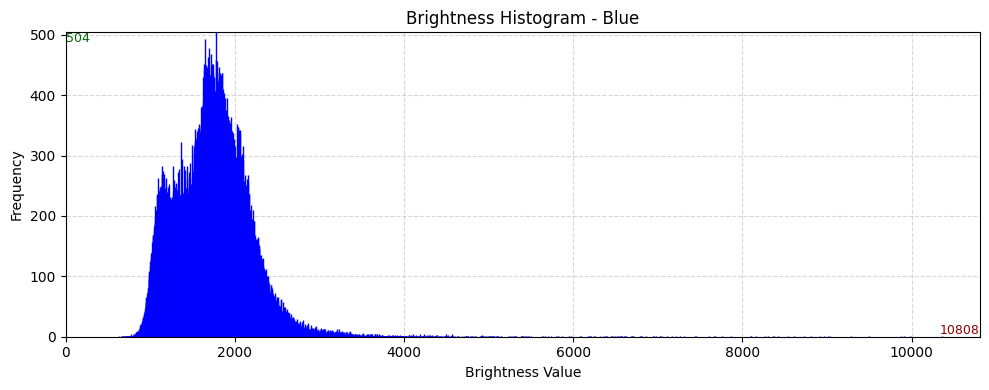


Layer: Green
  ▪ Max Brightness Value in Layer: 11680
  ▪ Max Frequency (Pixel Count): 620


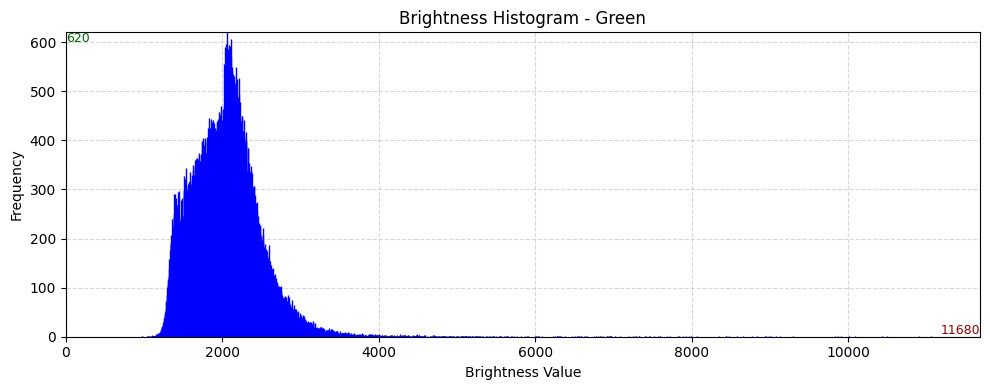


Layer: Red
  ▪ Max Brightness Value in Layer: 13432
  ▪ Max Frequency (Pixel Count): 526


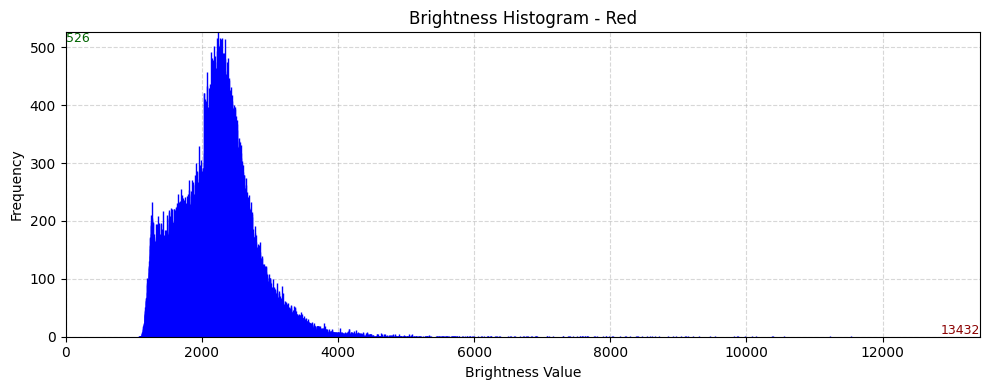


Layer: NIR
  ▪ Max Brightness Value in Layer: 14280
  ▪ Max Frequency (Pixel Count): 292


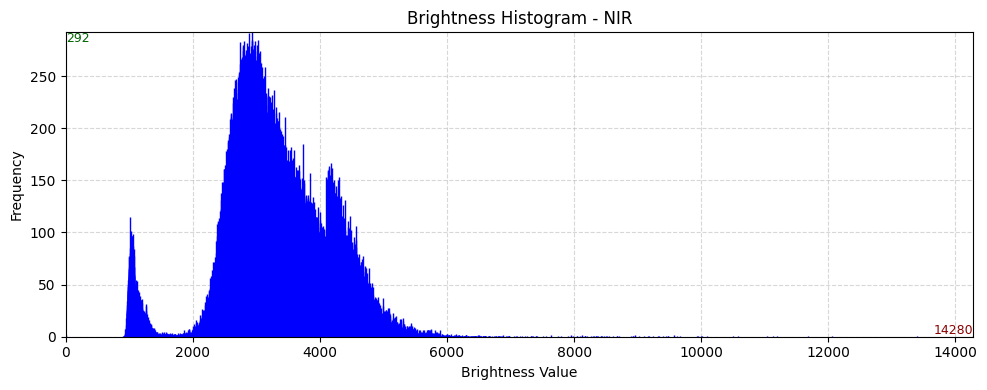

Saved histograms to drive


IMAGE CLASSIFICATION USING SUPPORT VECTOR MACHINE (SVM):




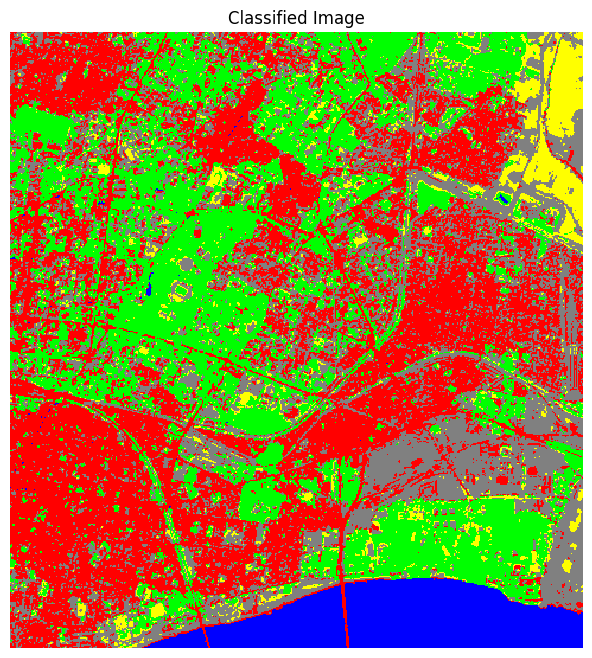

Saved Classified image to drive 


ACCURACY ASSESSMENT AND CONFUSION MATRIX:

Confusion Matrix:
Confusion Matrix Table:
  Classified Output agriculture  trees openland builtup  water Row Total Producer's Accuracy (%)
        agriculture          21      1        2       0      0        24                    87.5
              trees           2     33        0       0      0        35                   94.29
           openland           0      0       32       2      0        34                   94.12
            builtup           0      0        1      35      0        36                   97.22
              water           0      0        0       0     21        21                   100.0
       Column Total          23     34       35      37     21       150                        
User's Accuracy (%)        91.3  97.06    91.43   94.59  100.0                             94.67

Overall Accuracy: 94.67%


Saved Confusion Matrix to drive


In [1]:
# Install required packages
!pip install numpy pandas matplotlib seaborn scikit-learn rasterio fiona geopandas scikit-image

# Imports
import os
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
from rasterio.plot import show
from rasterio import features
from rasterio.features import rasterize
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Change to project_work directory
os.chdir('/content/drive/MyDrive/project_work')

# File Path (Sentinel Image)
raster_path = 'input_folder/image_prj_f.img'


# METADATA OF THE IMAGE -

print(f"\n")
print("METADATA:")
print(f"\n")

# --- Step 1: Open Raster Image
with rasterio.open(raster_path) as src:

# --- Step 2: Display File, Layer, and Statistics Info
    print("FILE INFO")
    print(f"  File Path: {raster_path}")
    print(f"  File Type: {src.driver} Image")
    print(f"  Number of Layers: {src.count}")
    print(f"  File Size: {round(os.path.getsize(raster_path) / (1024 * 1024), 2)} MB\n")

    print("LAYER INFO")
    print(f"  Width: {src.width}")
    print(f"  Height: {src.height}")
    print(f"  Block Width: {src.block_shapes[0][1]}")
    print(f"  Block Height: {src.block_shapes[0][0]}")
    print(f"  Type: Continuous")
    print(f"  Data Type: {src.dtypes[0]}")
    print(f"  Compression: {src.compression}")
    print()

    print("STATISTICS INFO (Excluding Zero Values)")
    band_means = []
    band_data = []

    for i in range(1, src.count + 1):
        band = src.read(i)
        masked_band = np.ma.masked_equal(band, 0)
        band_means.append(masked_band.mean())
        band_data.append(masked_band)

# --- Step 3: Compute and Display Band label based on Brightness Value
    sorted_indices = np.argsort(band_means)[::-1]  # Brightest to darkest
    guessed_labels = ["NIR", "Red", "Green", "Blue"][:src.count]
    band_label_map = dict(zip(sorted_indices + 1, guessed_labels))

    for i in range(1, src.count + 1):
        band = band_data[i - 1]
        label = band_label_map.get(i, f"Band {i}")
        print(f"  BAND {i} ({label}):")
        print(f"    ▪ Min: {band.min()}")
        print(f"    ▪ Max: {band.max()}")
        print(f"    ▪ Mean: {band.mean():.2f}")
        print(f"    ▪ Median: {np.ma.median(band)}")
        print(f"    ▪ Mode: {np.bincount(band.compressed()).argmax() if band.count() > 0 else 'N/A'}")
        print(f"    ▪ Std. Dev: {band.std():.2f}")
        print()
# --- Step 4: Display Map Info and Projection Info
    print(" MAP INFO")
    bounds = src.bounds
    print(f"  Upper Left X: {bounds.left}")
    print(f"  Upper Left Y: {bounds.top}")
    print(f"  Lower Right X: {bounds.right}")
    print(f"  Lower Right Y: {bounds.bottom}")
    print(f"  Pixel Size X: {src.res[0]}")
    print(f"  Pixel Size Y: {src.res[1]}")
    print(f"  Unit: meters\n")

    print("PROJECTION INFO")
    crs = src.crs
    print(f"  Projection: {crs.to_dict().get('proj', 'Unknown')}, Zone {crs.to_dict().get('zone', 'N/A')}")
    print(f"  Spheroid: {crs.to_dict().get('datum', 'Unknown')}")
    print(f"  Datum: {crs.to_dict().get('datum', 'Unknown')}")
    print(f"  EPSG Code: {crs.to_epsg()}")

    print(f"\n")

#BRIGHTNESS FREQUENCY HISTOGRAMS

    print("BRIGHTNESS FREQUENCY HISTOGRAMS:")

for i in range(1, src.count + 1):
    band = band_data[i - 1].compressed()
    label = band_label_map.get(i, f"Band {i}")

# --- Step 1: Compute Histogram data
    unique_vals, counts = np.unique(band, return_counts=True)

# --- Step 2: Get Brightness Value and Frequency Range
    max_brightness_value = unique_vals.max()
    max_frequency = counts.max()

    print(f"\nLayer: {label}")
    print(f"  ▪ Max Brightness Value in Layer: {max_brightness_value}")
    print(f"  ▪ Max Frequency (Pixel Count): {max_frequency}")

# --- Step 3: Plot Histogram with exact axis limits
    plt.figure(figsize=(10, 4))
    plt.title(f"Brightness Histogram - {label}")
    plt.xlabel("Brightness Value")
    plt.ylabel("Frequency")
    plt.vlines(unique_vals, 0, counts, color='blue', linewidth=1)

    # Set and enforce strict axis limits
    plt.xlim(0, max_brightness_value)
    plt.ylim(0, max_frequency)
    plt.axis([0, max_brightness_value, 0, max_frequency])
    plt.grid(True, linestyle='--', alpha=0.5)

    # Annotate max values on axes
    plt.text(max_brightness_value, 0, f"{max_brightness_value}", ha='right', va='bottom', fontsize=9, color='darkred')
    plt.text(0, max_frequency, f"{max_frequency}", ha='left', va='top', fontsize=9, color='darkgreen', rotation=0)

    plt.tight_layout()

# --- Step 4: Save Band Histograms to Drive
    histogram_path = f"output_folder/layer_histograms/band{i}_histogram.png"
    plt.savefig(histogram_path)
    plt.show()

print(f"Saved histograms to drive")

print(f"\n")

print("IMAGE CLASSIFICATION USING SUPPORT VECTOR MACHINE (SVM):")

print(f"\n")

# --- Step 1: File paths (Training shapefile and Classified Image)
polygon_shapefile = 'input_folder/shapefile.shp'
output_prediction_path = 'output_folder/lulc_classified_output.tif'

# --- Step 2: Read and prepare Training Polygons
gdf = gpd.read_file(polygon_shapefile)
gdf['id'] = range(len(gdf))
gdf = gdf[['geometry', 'labels', 'id']]

# --- Step 3: Sample Raster over Polygon geometries
with rasterio.open(raster_path) as src:
    img_crs = src.crs
    bands_data = src.read([4, 3, 2])  # NIR, Red, Green (band 4, 3, 2)
    transform = src.transform

points = []
labels = []

for _, row in gdf.iterrows():
    mask = rasterio.features.geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(bands_data.shape[1], bands_data.shape[2]))
    for y, x in zip(*np.where(mask)):
        pixel = bands_data[:, y, x]
        if np.any(np.isnan(pixel)):
            continue
        points.append(pixel.tolist())
        labels.append(row['labels'])

# --- Step 4: Create DataFrame
features = ['band1', 'band2', 'band3']
df = pd.DataFrame(points, columns=features)
df['labels'] = labels

# --- Step 5: Train-Test Split & SVM Model
X = df[features].values
y = df['labels'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

# --- Step 6: Predict full image
with rasterio.open(raster_path) as src:
    profile = src.profile
    profile.update(driver='GTiff', count=1, dtype='uint8', nodata=255)
    nir, red, green = src.read([4, 3, 2])
    stacked = np.stack([nir, red, green], axis=-1)
    reshaped = stacked.reshape(-1, 3)
    prediction = clf.predict(reshaped).reshape(stacked.shape[:2])

# --- Step 7: Display the Output Image

# Custom colormap for visualization
cmap_list = [
    (1, 1, 0),                    # 1: agriculture
    (0, 1, 0),                    # 2: trees
    (128/255, 128/255, 128/255),  # 3: openland
    (1, 0, 0),                    # 4: builtup
    (0, 0, 1),                    # 5: water
]
cmap = mcolors.ListedColormap(cmap_list)

plt.figure(figsize=(8, 8))
plt.imshow(prediction, cmap=cmap, interpolation='none')
plt.title("Classified Image")
plt.axis('off')
plt.show()

# --- Step 8: Save Classified Image
with rasterio.open(output_prediction_path, 'w', **profile) as dst:
    dst.write(prediction.astype('uint8'), 1)
    dst.write_colormap(1, {
        1: (255, 255, 0),    # agriculture - yellow
        2: (0, 255, 0),      # trees - green
        3: (128, 128, 128),  # openland - tan
        4: (255, 0, 0),      # builtup - red shade
        5: (0, 0, 255),      # water - blue
        255: (255, 255, 255) # nodata
    })
print(f"Saved Classified image to drive ")

print(f"\n")

print("ACCURACY ASSESSMENT AND CONFUSION MATRIX:")

# --- Step 1: Load Validation CSV
csv_path = 'input_folder/table_validation.csv'
df = pd.read_csv(csv_path, header=None, names=['id', 'x', 'y', 'class'])

# --- Class ID to Name Mapping
class_id_to_name = {
    1: 'agriculture',
    2: 'trees',
    3: 'openland',
    4: 'builtup',
    5: 'water'
}

# --- Step 2: Load Classified Image
classified_raster_path = 'output_folder/lulc_classified_output.tif'
with rasterio.open(classified_raster_path) as src:
    classified = src.read(1)
    transform = src.transform

# --- Step 3: Extract predicted labels using point coordinates
def get_rowcol_from_coords(x, y, transform):
    col, row = ~transform * (x, y)
    return int(row), int(col)

predicted_labels = []
true_labels = []

for idx, row in df.iterrows():
    try:
        px, py = row['x'], row['y']
        true_id = int(row['class'])
        r, c = get_rowcol_from_coords(px, py, transform)

        if (0 <= r < classified.shape[0]) and (0 <= c < classified.shape[1]):
            pred_id = int(classified[r, c])
            predicted_labels.append(class_id_to_name.get(pred_id, 'unknown'))
            true_labels.append(class_id_to_name.get(true_id, 'unknown'))
        else:
            print(f"Point at ({px}, {py}) is out of bounds.")
    except Exception as e:
        print(f"Error at index {idx}: {e}")

# --- Step 4: Compute Metrics
if len(true_labels) > 0 and len(predicted_labels) > 0:

    labels = list(class_id_to_name.values())

    # Confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    row_totals = cm.sum(axis=1)
    col_totals = cm.sum(axis=0)
    overall_total = cm.sum()

    # Accuracy calculations
    with np.errstate(divide='ignore', invalid='ignore'):
        producer_accuracy = np.round(np.nan_to_num(np.diag(cm) / row_totals) * 100, 2)
        user_accuracy = np.round(np.nan_to_num(np.diag(cm) / col_totals) * 100, 2)

    overall_accuracy = round((np.trace(cm) / overall_total) * 100, 2)

    # Create matrix
    data = []

    # Header row
    header_row = ["Classified Output"] + labels + ["Row Total", "Producer's Accuracy (%)"]
    data.append(header_row)

    # Rows for each class
    for i, label in enumerate(labels):
        row = [label] + list(cm[i]) + [row_totals[i], producer_accuracy[i]]
        data.append(row)

    # Column Total row
    col_total_row = ["Column Total"] + list(col_totals) + [overall_total, ""]
    data.append(col_total_row)

    # User's Accuracy row
    users_row = ["User's Accuracy (%)"] + list(user_accuracy) + ["", overall_accuracy]
    data.append(users_row)

    # Create DataFrame
    df_excel_format = pd.DataFrame(data)

# --- Step 5: Print Confusion Matrix
    print("\nConfusion Matrix:")
    print("Confusion Matrix Table:")
    print(df_excel_format.to_string(index=False, header=False))
    print(f"\nOverall Accuracy: {round(overall_accuracy, 2)}%")

# --- Step 6: Save the Confusion Matrix
output_csv_path = 'output_folder/confusion_matrix.csv'
df_excel_format.to_csv(output_csv_path, index=False, header=False)

print(f"\n")
print(f"Saved Confusion Matrix to drive")

In [ ]:
from google.colab import drive
drive.flush_and_unmount()